original code taken from here: https://www.kaggle.com/aadharsh0428/hc-detection-using-pytorch/code


**fastai Import**

In [ ]:
import fastai
from fastai import *
from fastai.vision import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Intall pytorch 1.4**

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"


**Read Data from folder**

In [ ]:

db = ImageDataBunch.from_folder(
    "/content/drive/My Drive/data/",
    
    valid_pct=0.15,  # split Valid set
    bs=64,
    size=224,
    ds_tfms=get_transforms(),
)
db = db.normalize(imagenet_stats)

**try to show the pics from dataset**

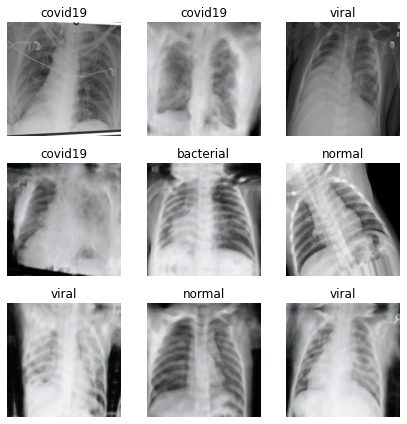

In [ ]:
db.show_batch(rows=3, figsize=(6,6))


**Use resnet 50 to build model**

In [ ]:
learn = cnn_learner(db, models.resnet50, metrics=[accuracy, ], model_dir="/tmp/models", callback_fns=ShowGraph)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.070127,0.400657,0.838063,23:35
1,0.721944,0.271075,0.894825,00:57
2,0.558896,0.214863,0.914858,00:57
3,0.461703,0.188608,0.923205,00:57
4,0.379289,0.155913,0.948247,00:57
5,0.322149,0.129896,0.954925,00:56
6,0.274867,0.109051,0.964942,00:57
7,0.261395,0.112767,0.959933,00:57
8,0.235554,0.090488,0.966611,00:57
9,0.203494,0.080249,0.964942,00:57


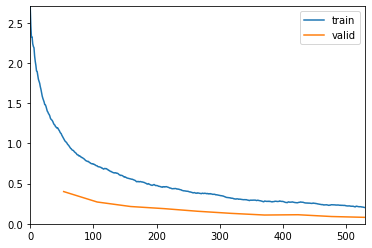

In [ ]:
learn.fit(10,lr=1e-4)

In [1]:
learn.train_loss

**Test Cuda and try to train the model**

In [ ]:
defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(3)

**try to find the best learning rate**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


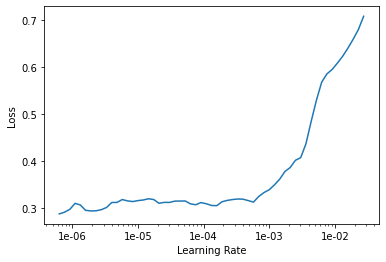

In [ ]:
learn.unfreeze()  # unfreeze all layers
learn.lr_find()  # iterativ
learn.recorder.plot()

**train the model**

In [ ]:
learn.fit_one_cycle(10,max_lr=slice(1e-4, 1e-3))


**calculate the confusion matrix**

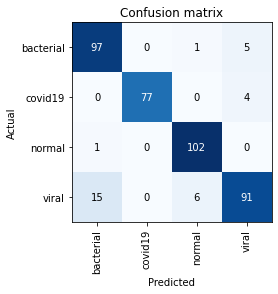

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**plot the top loss**

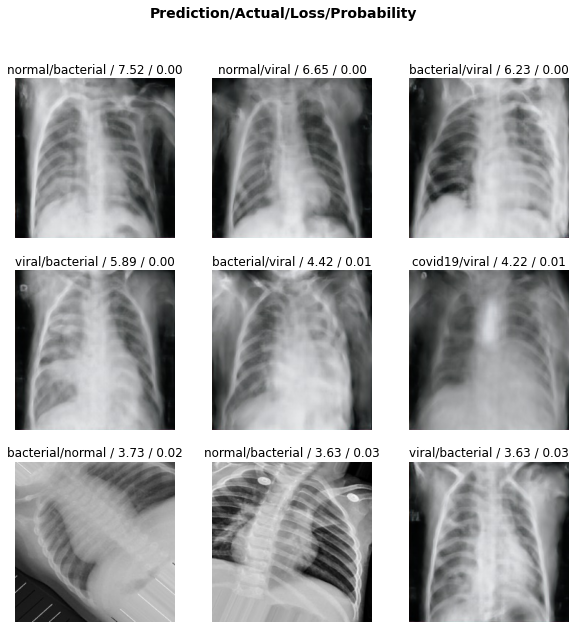

In [ ]:
interp.plot_top_losses(9, figsize=(10,10))


**save model**

In [ ]:
learn.save("/content/drive/My Drive/model/trained_model5")


**plot heat map (Grad CAM)**

In [ ]:
from fastai.callbacks.hooks import *
import cv2
import matplotlib.pyplot as plt
import random

# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index, learner, imgDataBunch):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = imgDataBunch.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = imgDataBunch.one_item(tensorImg)
    oneBatch_im = vision.Image(imgDataBunch.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, learner, imgDataBunch, classes=['bacterial', 'covid19', 'normal', 'viral']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = random.randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.preds[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

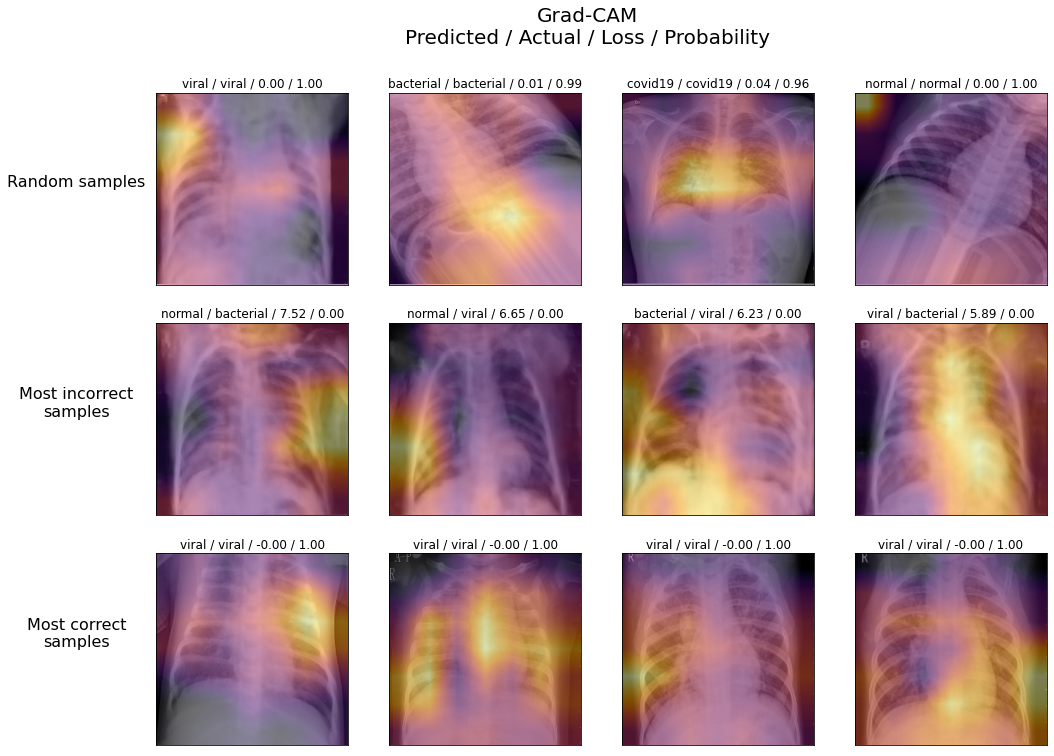

In [ ]:
plot_heatmap_overview(interp, learn, db)

**read the evaluation dataset**

In [ ]:
import glob
Path0=glob.glob("/content/drive/My Drive/Valid/bacterial/*.jpeg")
Path1=glob.glob("/content/drive/My Drive/Valid/covid19/*.jpeg")
Path2=glob.glob("/content/drive/My Drive/Valid/normal/*.jpeg")
Path3=glob.glob("/content/drive/My Drive/Valid/viral/*.jpeg")


In [ ]:
preds = []
ytrue= []
size=224
for i in range(len(Path0)):
    a=[]
    a.append(Path0[i])
    a.append(0)
    preds.append(a)

for i in range(len(Path1)):
    a=[]
    a.append(Path1[i])
    a.append(1)
    preds.append(a)

for i in range(len(Path2)):
    a=[]

    a.append(Path2[i])
    a.append(2)
    preds.append(a)

for i in range(len(Path3)):
    a=[]
    a.append(Path3[i])
    a.append(3)
    preds.append(a)

In [ ]:
print(preds[0])

['/content/drive/My Drive/Valid/bacterial/_500_4806066.jpeg', 0]


**shuffle the dataset**

In [ ]:
import random
print(len(preds))
random.shuffle(preds)
print(preds[0][0])
a=open_image(preds[0][0])

800
/content/drive/My Drive/Valid/viral/71.jpeg


**do the prediction with model**

In [ ]:
predict=[]
for i in range(len(preds)):
    cc=preds[i][0]
    a=open_image(preds[i][0])
    a.resize(size)
    p = learn.predict(a)
    p=int(p[1])
    predict.append(p)
    ytrue.append(preds[i][1])
    

In [ ]:
print(predict[0])

3


**calculate the recall f1 score matrix**

In [ ]:
from sklearn.metrics import classification_report
print("[INFO] evaluating network...")
classes=['bacterial', 'covid19', 'normal', 'viral']

print(classification_report(ytrue, predict,target_names=classes))